In [10]:
import requests
import pickle
import matplotlib.pyplot as plt
# %matplotlib inline

In [18]:
# af lep
r_json = requests.get('http://drgmk.com/sdb/seds/masters/sdb-v2-052704.76-115403.5/public/sdb-v2-052704.76-115403.5-mnest/phoenix_sol+modbb_disk_r_.json')

s = requests.get('http://drgmk.com/sdb/seds/masters/sdb-v2-052704.76-115403.5/public/sdb-v2-052704.76-115403.5-mnest/phoenix_m+modbb_disk_r_.pkl')

r = pickle.loads(s.content)

In [3]:
# print the model component fluxes for the MIRI bands
print(f'filter: {r.model_comps}, total')
for i,f in enumerate(r.all_filters):
    if 'NIRCAM' in f:
        print(f, r.all_comp_phot[:,i], r.all_phot[i])



filter: ('phoenix_m', 'modbb_disk_r'), total
NIRCAM.F150W [1.14340805e+01 1.01728097e-39] 11.434080460590383
NIRCAM.F405N [2.29713352e+00 4.58817144e-18] 2.2971335218718485
NIRCAM.F323N [3.50989217e+00 1.11792046e-22] 3.509892170263347
NIRCAM.F210M [7.41814060e+00 9.33090067e-36] 7.418140604279268
NIRCAM.F150W2 [1.03667093e+01 2.41631529e-34] 10.366709260199471
NIRCAM.F212N [7.26566709e+00 3.07709631e-36] 7.265667088362662
NIRCAM.F444W [2.00734606e+00 2.11221294e-15] 2.0073460635958673
NIRCAM.F322W2 [3.76294914e+00 1.68998694e-19] 3.7629491409314846
NIRCAM.F356W [2.97992007e+00 2.09684214e-19] 2.9799200687951717
NIRCAM.F410M [2.29581404e+00 1.38107011e-17] 2.295814039446053
NIRCAM.F187N [8.57167941e+00 1.32502193e-38] 8.571679410440579
NIRCAM.F430M [2.08808830e+00 5.93166797e-17] 2.0880883027426957
NIRCAM.F277W [4.70894258e+00 5.21522770e-20] 4.708942579195029
NIRCAM.F090W [1.34273814e+01 2.45864034e-38] 13.4273814227891
NIRCAM.F070W [1.32054432e+01 5.30506605e-38] 13.205443165214213
N

In [4]:
# print the model component fluxes for the MIRI bands
print(f'filter: {r.model_comps}, total')
for i,f in enumerate(r.all_filters):
    if 'NIRCAM.F444W' in f:
        print(f, r.all_comp_phot[:,i], r.all_phot[i])
        dist = r.distributions['all_phot'][i]

filter: ('phoenix_m', 'modbb_disk_r'), total
NIRCAM.F444W [2.00734606e+00 2.11221294e-15] 2.0073460635958673
NIRCAM.F444WC [2.02340116e+00 3.19471794e-08] 2.0234011992080667


In [6]:
import numpy as np
def calc_mag_err(dist):
#     −2.5⋅log10(fluxJy)+8.90
    mag_e = -2.5/np.log(10/3630.78)*(np.std(dist)/np.median(dist))
    return mag_e

In [7]:
# print the model component fluxes for the MIRI bands
print(f'filter: {r.model_comps}, total')

filters = ['NIRCAM.F200W', 'NIRCAM.F356W', 'NIRCAM.F444W']

errs = []
for i,f in enumerate(filters):
#     if 'MIRI.F1550C' in f:
    print(f, r.all_comp_phot[:,i], r.all_phot[i])
    dist = r.distributions['all_phot'][i]
    err = calc_mag_err(dist)
    print('err', err)
    errs.append(err)

filter: ('phoenix_m', 'modbb_disk_r'), total
NIRCAM.F200W [0.35464279 0.16384041] 0.35464279498770956
err 0.002773909429007033
NIRCAM.F356W [ 0.1807062  -0.01934639] 0.1807062002726325
err 0.0302418599954501
NIRCAM.F444W [ 0.38707533 -0.15953311] 0.3870753309845192
err 0.037934753620330594


In [8]:
errs

[0.002773909429007033, 0.0302418599954501, 0.037934753620330594]

In [14]:
%matplotlib inline

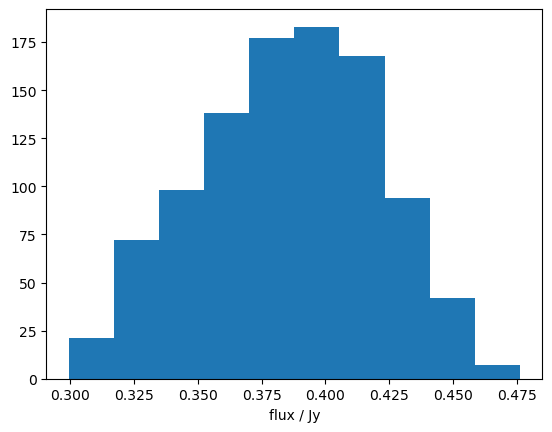

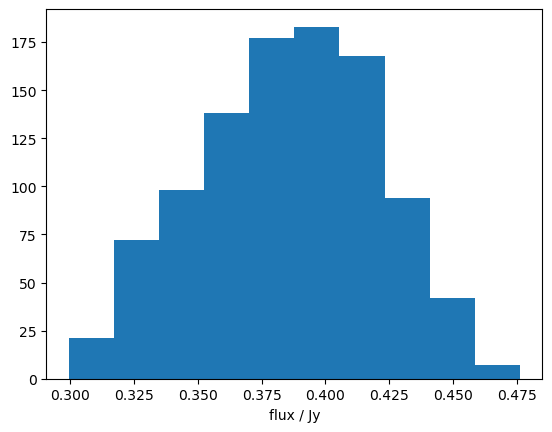

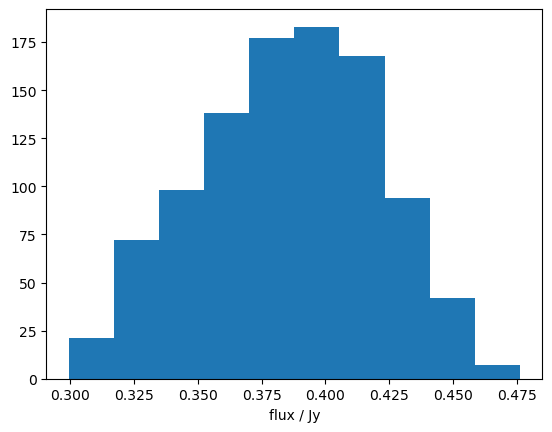

In [15]:
fig, ax = plt.subplots()
ax.hist(dist)
ax.set_xlabel('flux / Jy')
plt.show()

In [26]:
import json

stellar_jason = r_json.json()

In [27]:
plt.rcParams['font.family'] = 'monospace'   # Fonts
plt.rcParams['font.monospace'] = 'DejaVu Sans Mono'

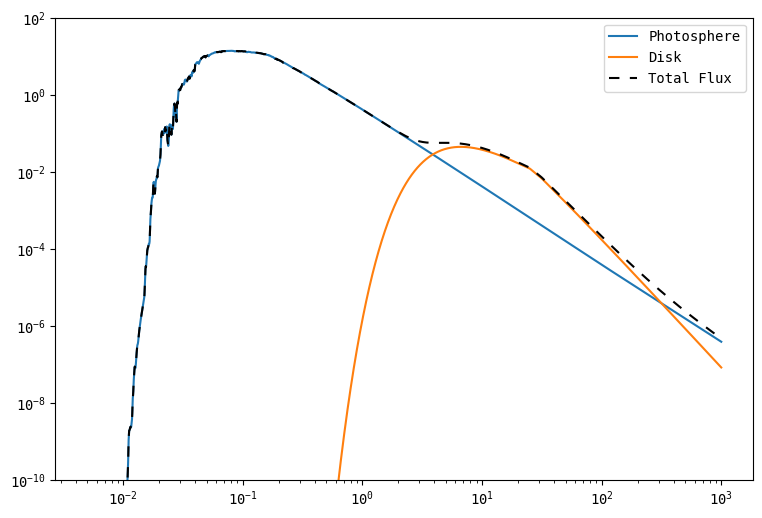

In [28]:
import numpy as np
import matplotlib.pyplot as plt
plt.figure(figsize=(9,6))

plt.plot(np.array(stellar_jason['star_spec']['wavelength'])/10, stellar_jason['star_spec']['fnujy'], label='Photosphere')
plt.plot(np.array(stellar_jason['star_spec']['wavelength'])/10, stellar_jason['disk_spec']['fnujy'], label='Disk')

wavel = np.array(stellar_jason['star_spec']['wavelength'])
combflux = np.array(stellar_jason['star_spec']['fnujy'])+np.array(stellar_jason['disk_spec']['fnujy'])
modelspec = np.array([wavel, combflux])

plt.plot(np.array(stellar_jason['star_spec']['wavelength'])/10, combflux, '--', dashes=(5, 5), label='Total Flux', c='k')


plt.yscale('log')
plt.xscale('log')
plt.legend()
plt.ylim(bottom=1e-10, top=1e2)
# plt.xlim(0.05, 10000)
plt.show()


In [29]:
np.savetxt('./AFLepb_sdf.txt', modelspec.T)

In [6]:
import os

import astropy.io.fits as pyfits
import matplotlib.pyplot as plt
import numpy as np

import astropy.units as u

from scipy.interpolate import RegularGridInterpolator
from scipy.ndimage import fourier_shift, rotate, shift
from scipy.optimize import minimize
from synphot import Observation, SourceSpectrum, SpectralElement
from synphot.models import Empirical1D
from synphot.units import convert_flux

# import pyklip.instruments.JWST as JWST
import webbpsf, webbpsf_ext
from webbpsf_ext import robust

from jwst import datamodels
from jwst.datamodels import dqflags
from jwst.coron import AlignRefsStep

import spaceKLIP.io as io

def get_stellar_magnitudes(sdir):
    
    # Get the instrument
    instrument = 'NIRCAM'

    # Check if this is a Vizier VOTable, if so, use webbpsf_ext
    if sdir[-4:] == '.vot':
        # Pick an arbitrary bandpass+magnitude to normalise the initial SED. Exact choice
        # doesn't matter as will be be refitting this model using the provided data.
        # Important thing is the spectral type (user provided).
        bp_k = webbpsf_ext.bp_2mass('k')
        bp_mag = 5

        # Magnitude value is arbitrary, as we will be using the Vizier photometry to renormalise and fit the SED.
        spec = webbpsf_ext.spectra.source_spectrum(name='Input Data + SED', sptype='K5V', mag_val=bp_mag, bp=bp_k, votable_file=sdir)

        # Want to adjust where we fit the spectrum based on the observing filter, just roughly split between NIRCam and MIRI
        if instrument == 'NIRCAM' :
            wlim = [1,5]
        elif instrument == 'MIRI':
            wlim = [10, 20]

        # Fit the SED to the selected data
        spec.fit_SED(x0=[1.0], wlim=wlim, use_err=False, verbose=False) #Don't use the error as it breaks thing, and don't print scaling value.
        # spec.plot_SED()
        # plt.show()

        # Want to convert the flux to photlam so that it matches the per photon throughputs?
        input_flux = u.Quantity(spec.sp_model.flux, str(spec.sp_model.fluxunits))
        photlam_flux = convert_flux(spec.sp_model.wave, input_flux, out_flux_unit='photlam')

        # Spectrum is originally from pysynphot (outdated), convert to synphot.
        SED = SourceSpectrum(Empirical1D, points=spec.sp_model.wave << u.Unit(str(spec.sp_model.waveunits)), lookup_table=photlam_flux << u.Unit('photlam'))
    # If not a VOTable, try to read it in.
    else:
        SED = io.read_spec_file(sdir)

    ### Now, perform synthetic observations on the SED to get stellar magnitudes
    # Get the filters used from the input datasets
    filters = ['F200W', 'F410M']
    
    # Calculate magnitude in each filter
    mstar = {}
    for filt in filters:
        # Read in the bandpass correctly
        bpstring = '/Users/wbalmer/spaceKLIP/resources/PCEs/{}/{}.txt'.format(instrument, filt)
        bpfile = os.path.join(bpstring)

        with open(bpfile) as bandpass_file:
            bandpass_data = np.genfromtxt(bandpass_file).transpose()
            bandpass_wave = bandpass_data[0] * 1e4 #Convert from microns to angstrom
            bandpass_throughput = bandpass_data[1]

        # Create the bandpass object
        Bandpass = SpectralElement(Empirical1D, points=bandpass_wave, lookup_table=bandpass_throughput)

        # Perform synthetic observation
        Obs = Observation(SED, Bandpass, binset=Bandpass.waveset)
        VegaSED = SourceSpectrum.from_vega()
        magnitude = Obs.effstim(flux_unit='vegamag', vegaspec=VegaSED).value

        # Add magnitude to dictionary
        mstar[filt.upper()] = magnitude

    return mstar

In [7]:
get_stellar_magnitudes('../as209-firstlook/AS209_sdf_phoenix_m+modbb_disk_r+modbb_disk_r.txt')

{'F200W': 7.33625470044688, 'F410M': 6.926410523896244}

In [8]:
get_stellar_magnitudes('../as209-firstlook/as209_photometry.vot')

{'F200W': 7.599961449111463, 'F410M': 7.519856358753575}